In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro import plate
import matplotlib.pyplot as plt


from torch import nn
class SVI_recommender(nn.Module):
    def __init__(self, U, V):
        super(SVI_recommender, self).__init__()
        self.U = U
        self.V = V

    def predict(self, user_ids, item_ids):
        uservec = self.U[user_ids]
        itemvec = self.V[item_ids]
        preds = (uservec * itemvec).sum(1)
        return preds.numpy()
d = 2

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


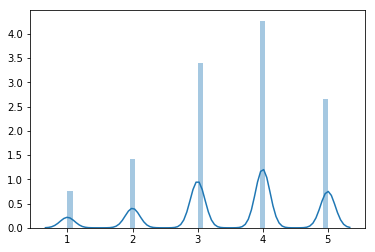

In [2]:
ds = get_movielens_dataset(variant='100K')

items = pd.read_csv("movies.dat", delimiter="::", header=None, engine = "python")
items.columns = ['itemId', 'name','genre']
ind2item = {row.itemId : row.name for row in items.itertuples()}

train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## pyro implementation

## TODO:
- Create parameters for per-user and per item uncertainty. Possible to use multivariate normal like this:
````
means = torch.randn(2,3)
a = torch.ones(2, 3)
covar = torch.diag_embed(a)
MultivariateNormal(means, covar).sample()
````


- Enable more advanced uncertainty than in diagonals?
- the BMCMC paper does not think there is any necessity to add uncertainty in the observation uncertainty. Spills over in user and item uncertainty. Correct?

In [3]:
pyro.clear_param_store()
def model(dat):
    mu0 = torch.zeros(d)
    var0 = torch.diag(torch.ones(d))*0.2

    muU = pyro.sample("muU", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
    muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
    varU = varV = var0
    obsvar = pyro.sample("obsvar", dist.Exponential(rate= 10.0))
    
    with plate("user_loop", dat.num_users) as i:
        U = pyro.sample(f"u_", dist.MultivariateNormal(muU, varU))
        
    with plate("item_loop", dat.num_items) as i:
        V = pyro.sample(f"i_", dist.MultivariateNormal(muV, varV))
    
    
    with plate("data_loop", size = len(dat.ratings)) as k:
        u = U[dat.user_ids[k]]
        v = V[dat.item_ids[k]]
        score = u.mul(v).sum(1)
        r = torch.tensor(dat.ratings[k])
        pyro.sample(f"obs", dist.Normal(loc = score, scale = 1.0), obs=r)

In [4]:
def guide(dat):
    obsvar_rate = pyro.param("obsvar_rate", torch.tensor(10.0), constraint = constraints.positive)
    obsvar = pyro.sample("obsvar", dist.Exponential(obsvar_rate))
    
    varU = pyro.param("varU", torch.ones(d), constraint = constraints.positive)
    user_var = pyro.param("user_var_factor", torch.rand(dat.num_users)+0.5, constraint = constraints.positive)
    covarU = torch.diag(varU)*user_var.view(-1,1,1)
    
    varV = pyro.param("varV", torch.ones(d), constraint = constraints.positive)
    item_var = pyro.param("item_var_factor", torch.rand(dat.num_items)+0.5, constraint = constraints.positive)
    covarV = torch.diag(varV)*item_var.view(-1,1,1)
    
    muUpar = pyro.param("muUpar", torch.rand(d)-0.5)
    muVpar = pyro.param("muVpar", torch.rand(d)-0.5)

    # Global vars:
    muU = pyro.sample("muU", dist.MultivariateNormal(loc = muUpar, covariance_matrix= covarU))
    muV = pyro.sample("muV", dist.MultivariateNormal(loc = muVpar, covariance_matrix= covarV))

    ## user latent vectors
    U = pyro.param("user_mat", torch.rand(dat.num_users, d)-0.5)
    V = pyro.param("item_mat", torch.rand(dat.num_items, d)-0.5)
    

    with plate("user_loop", dat.num_users) as i:
        U = pyro.sample(f"u_", dist.MultivariateNormal(U[i,], covarU[i,]))
        

    ## item latent vectors
    with plate("item_loop", dat.num_items) as i:
        U = pyro.sample(f"i_", dist.MultivariateNormal(V[i,], covarV))

In [5]:
%%time
n_steps = 200
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    loss = svi.step(train)

    if step%10== 0:
        # RMSE
        svimodel = SVI_recommender(U = pyro.param("user_mat").detach(), 
                   V = pyro.param("item_mat").detach())
        rmse_test = rmse_score(svimodel, test)
        print(f"step: {step} \t loss: {loss:.0f} \t test-rmse: {rmse_test:.2f}")

step: 0 	 loss: 756204 	 test-rmse: 3.71
step: 10 	 loss: 649961 	 test-rmse: 3.70
step: 20 	 loss: 623324 	 test-rmse: 3.66
step: 30 	 loss: 551014 	 test-rmse: 3.36
step: 40 	 loss: 327436 	 test-rmse: 2.31
step: 50 	 loss: 169278 	 test-rmse: 1.16
step: 60 	 loss: 156447 	 test-rmse: 1.08
step: 70 	 loss: 137943 	 test-rmse: 1.01
step: 80 	 loss: 134129 	 test-rmse: 0.99
step: 90 	 loss: 130064 	 test-rmse: 0.95
step: 100 	 loss: 129022 	 test-rmse: 0.95
step: 110 	 loss: 128100 	 test-rmse: 0.95
step: 120 	 loss: 127487 	 test-rmse: 0.95
step: 130 	 loss: 127148 	 test-rmse: 0.94
step: 140 	 loss: 126824 	 test-rmse: 0.94
step: 150 	 loss: 126531 	 test-rmse: 0.94
step: 160 	 loss: 126477 	 test-rmse: 0.94
step: 170 	 loss: 126224 	 test-rmse: 0.94
step: 180 	 loss: 125987 	 test-rmse: 0.93
step: 190 	 loss: 125754 	 test-rmse: 0.93
CPU times: user 1min 30s, sys: 1.19 s, total: 1min 31s
Wall time: 1min 35s


## Print uncertainty factors vs number of activity on user and items

User activity/uncertainty correlation: -0.64


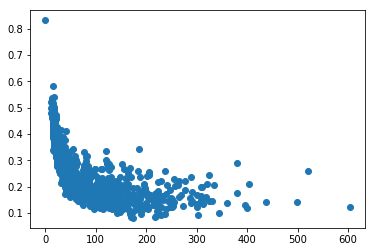

Item activity/uncertainty correlation: -0.65


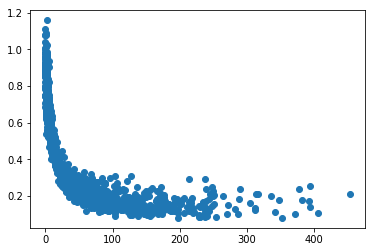

In [6]:
def get_counts(sequence, num):
    ids, id_count = np.unique(sequence, return_counts=True)
    counts = np.zeros(num)
    counts[ids] = id_count
    return counts

user_counts = get_counts(train.user_ids, train.num_users)#[1:]
user_factors = pyro.param("user_var_factor").detach().numpy()#[1:]
print(f"User activity/uncertainty correlation: {np.corrcoef(user_factors, user_counts)[1,0]:.2f}")
_ = plt.plot(user_counts, user_factors, "o")
plt.show()

item_counts = get_counts(train.item_ids, train.num_items)
item_factors = pyro.param("item_var_factor").detach().numpy()
print(f"Item activity/uncertainty correlation: {np.corrcoef(item_factors, item_counts)[1,0]:.2f}")
_ = plt.plot(item_counts, item_factors, "o")
plt.show()

# Plot distribution of user vectors

Random users:


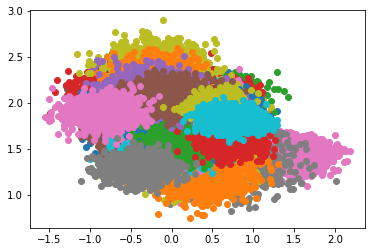

Most and least seen user:


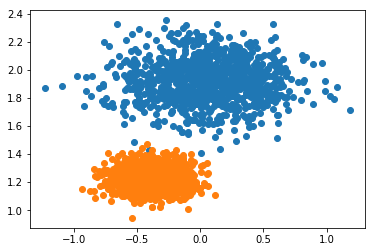

In [7]:
def plot_distr_of_users(u):
    u_means = pyro.param("user_mat")[u,]
    u_covars = torch.diag(pyro.param("varU")) * (pyro.param("user_var_factor")[u,].view(-1,1,1))
    user_distr = torch.distributions.MultivariateNormal(u_means, u_covars)

    samples = user_distr.sample(torch.tensor([1000])).numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")
        

print("Random users:")
u = torch.randint(low=0, high=train.num_users, size = (50,))
plot_distr_of_users(u)
plt.show()

u = np.array([user_counts.argsort()[1], user_counts.argmax()])
print("Most and least seen user:")
plot_distr_of_users(u)

Random items:


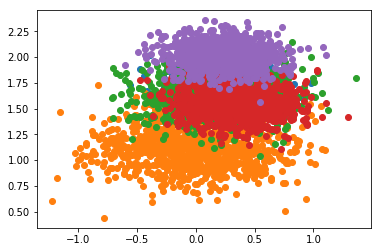

Most and least seen item:


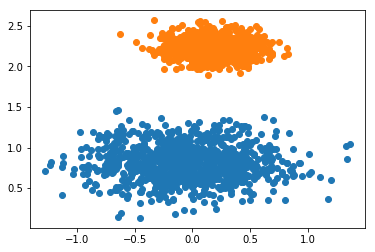

In [8]:
u = torch.randint(low=0, high=train.num_items, size = (5,))
def plot_distr_of_items(u):
    u_means = pyro.param("item_mat")[u,]
    u_covars = torch.diag(pyro.param("varV")) * (pyro.param("item_var_factor")[u,].view(-1,1,1))
    user_distr = torch.distributions.MultivariateNormal(u_means, u_covars)

    samples = user_distr.sample(torch.tensor([1000])).numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

print("Random items:")
plot_distr_of_items(u)
plt.show()

u = np.array([item_counts.argsort()[1], item_counts.argmax()])
print("Most and least seen item:")
plot_distr_of_items(u)